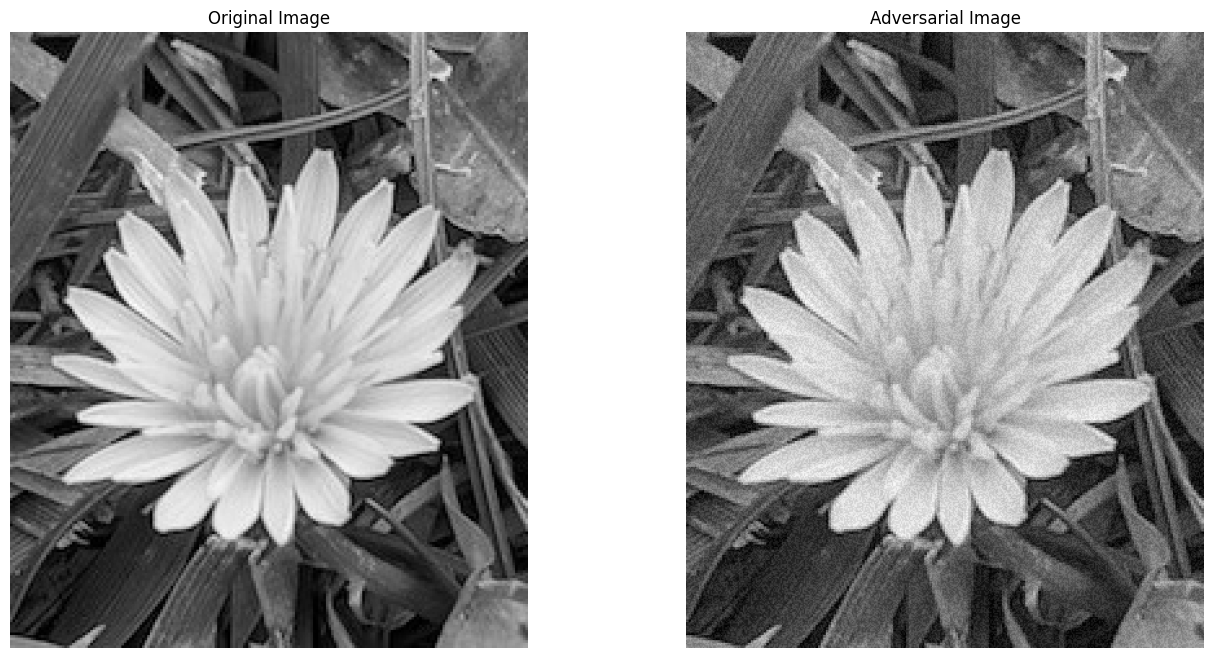

In [1]:
# ---------------------- Adversarial Image Generation: FGSM ----------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load original image
image = cv2.imread('flower.png', cv2.IMREAD_GRAYSCALE)
# Create noise
noise = np.random.normal(0, 25, image.shape).astype('uint8')
# Add noise to create adversarial image
adversarial_image = cv2.addWeighted(image, 1.0, noise, 0.1, 0)

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 8))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot adversarial image
plt.subplot(1, 2, 2)
plt.imshow(adversarial_image, cmap='gray')
plt.title('Adversarial Image')
plt.axis('off')

plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
batch_size = 64
num_epochs = 20
lr = 0.0001
beta1 = 0.5

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Network
generator = nn.Sequential(
    nn.Linear(latent_dim, 128),  # Fully connected layer: maps input noise to 128 features
    nn.ReLU(),                   # Activation function: introduces non-linearity
    nn.Linear(128, 256),         # Expands the feature space to 256 dimensions
    nn.ReLU(),                   # Another activation function to make learning non-linear
    nn.Linear(256, 28 * 28),     # Output layer: maps features to 784 pixels (28x28 image)
    nn.Tanh()                    # Scales output pixel values to the range [-1, 1]
).to(device)

# Discriminator Network
discriminator = nn.Sequential(
    nn.Linear(28 * 28, 256),     # Input layer: takes flattened 28x28 image (784 pixels)
    nn.LeakyReLU(0.2),           # Activation: allows small gradients for negative inputs (slope = 0.2)
    nn.Linear(256, 128),         # Hidden layer: reduces features to 128 dimensions
    nn.LeakyReLU(0.2),           # Another activation for non-linearity
    nn.Linear(128, 1),           # Output layer: maps features to a single value (real/fake score)
    nn.Sigmoid()                 # Activation: outputs probability [0, 1] (real = 1, fake = 0)
).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training function to save generated images
def save_generated_images(epoch, generator, fixed_noise):
    with torch.no_grad():
        fake_images = generator(fixed_noise).reshape(-1, 28, 28)
        fake_images = fake_images.cpu().numpy()
        
        plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./fake_images/fake_images_epoch_{epoch}.png')
        plt.close()

# Generate fixed noise for visualization
fixed_noise = torch.randn(25, latent_dim, device=device)

# Training loop
print("Starting Training...")

for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.reshape(-1, 28*28).to(device)
        
        # Create labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # -----------------
        # Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        
        # Calculate loss for real images
        real_output = discriminator(real_imgs)
        real_loss = criterion(real_output, real_labels)
        
        # Calculate loss for fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise)
        fake_output = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_output, fake_labels)
        
        # Total loss for the Discriminator
        d_loss = real_loss + fake_loss
        
        # Backpropagation
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Get the discriminator's predictions for the fake images
        output = discriminator(fake_imgs)
        
        # Calculate Generator's loss
        g_loss = criterion(output, real_labels)
        
        # Backpropagation
        g_loss.backward()
        optimizer_G.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(dataloader)}] '
                  f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')
    
    # Save generated images every 2 epochs
    if (epoch + 1) % 2 == 0:
        save_generated_images(epoch + 1, generator, fixed_noise)

# Save the trained models
print("Saving models...")
torch.save(generator.state_dict(), './GAN_models/generator.pth')
torch.save(discriminator.state_dict(), './GAN_models/discriminator.pth')

print("Training finished!")

Starting Training...
Epoch [0/20] Batch [0/938] d_loss: 1.4241 g_loss: 0.7374
Epoch [0/20] Batch [100/938] d_loss: 1.2017 g_loss: 0.5575
Epoch [0/20] Batch [200/938] d_loss: 1.1637 g_loss: 0.7381
Epoch [0/20] Batch [300/938] d_loss: 0.8358 g_loss: 1.0534
Epoch [0/20] Batch [400/938] d_loss: 0.5990 g_loss: 1.3516
Epoch [0/20] Batch [500/938] d_loss: 0.4579 g_loss: 1.9243
Epoch [0/20] Batch [600/938] d_loss: 0.3757 g_loss: 1.8284
Epoch [0/20] Batch [700/938] d_loss: 0.3770 g_loss: 2.1819
Epoch [0/20] Batch [800/938] d_loss: 0.5281 g_loss: 2.5660
Epoch [0/20] Batch [900/938] d_loss: 0.4656 g_loss: 2.3836
Epoch [1/20] Batch [0/938] d_loss: 0.4301 g_loss: 2.4634
Epoch [1/20] Batch [100/938] d_loss: 0.3791 g_loss: 2.6107
Epoch [1/20] Batch [200/938] d_loss: 0.3998 g_loss: 2.2814
Epoch [1/20] Batch [300/938] d_loss: 0.3630 g_loss: 3.4591
Epoch [1/20] Batch [400/938] d_loss: 0.4314 g_loss: 3.3432
Epoch [1/20] Batch [500/938] d_loss: 0.3350 g_loss: 2.7967
Epoch [1/20] Batch [600/938] d_loss: 0.

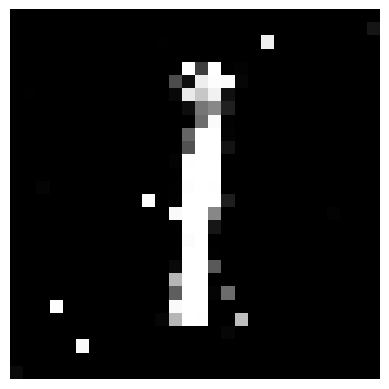

In [34]:
# 加载保存的生成器模型
generator.load_state_dict(torch.load('./GAN_models/generator.pth'))

# 生成新的手写数字图像
with torch.no_grad():
    # 生成随机噪声
    noise = torch.randn(1, latent_dim).to(device)
    # 使用生成器生成图像
    fake_image = generator(noise).reshape(28, 28)
    # 显示生成的图像
    plt.imshow(fake_image.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        # U-Net like architecture
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 2, stride=2)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )

    def forward(self, x, t):
        # Embedding time step t
        t = t.unsqueeze(-1).unsqueeze(-1)
        t_embed = t.expand(-1, -1, x.shape[2], x.shape[3])
        
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        
        # Decoder
        d1 = self.dec1(e2)
        d2 = self.dec2(torch.cat([d1, e1], dim=1))
        
        return d2

class DiffusionTrainer:
    def __init__(self, timesteps=1000):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.timesteps = timesteps
        self.model = DiffusionModel().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.mse = nn.MSELoss()
        
        # Define noise schedule (linear)
        self.beta = torch.linspace(1e-4, 0.02, timesteps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    
    def add_noise(self, x, t):
        """Add noise to image x at timestep t"""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])
        epsilon = torch.randn_like(x)
        
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * epsilon, epsilon
    
    def train_step(self, x):
        """Single training step"""
        t = torch.randint(0, self.timesteps, (x.shape[0],)).to(self.device)
        noisy_x, noise = self.add_noise(x, t)
        predicted_noise = self.model(noisy_x, t.float()/self.timesteps)
        
        loss = self.mse(predicted_noise, noise)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def sample(self, n_samples, size=(1, 28, 28)):
        """Generate samples using the model"""
        self.model.eval()
        with torch.no_grad():
            x = torch.randn((n_samples, *size)).to(self.device)
            
            for t in reversed(range(self.timesteps)):
                t_batch = torch.ones(n_samples).to(self.device) * t
                predicted_noise = self.model(x, t_batch.float()/self.timesteps)
                
                alpha_t = self.alpha[t]
                alpha_bar_t = self.alpha_bar[t]
                
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                    
                x = 1/torch.sqrt(alpha_t) * (x - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * predicted_noise) + \
                    torch.sqrt(self.beta[t]) * noise
                
        self.model.train()
        return x
    
    def save_samples(self, samples, epoch):
        """Save generated samples as image"""
        samples = samples.cpu().numpy()
        
        plt.figure(figsize=(10, 10))
        for i in range(min(25, len(samples))):
            plt.subplot(5, 5, i+1)
            plt.imshow(samples[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'diffusion_samples_epoch_{epoch}.png')
        plt.close()

# Training setup
def train_diffusion():
    # Hyperparameters
    batch_size = 128
    num_epochs = 100
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize trainer
    trainer = DiffusionTrainer()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(dataloader):
            images, _ = batch
            images = images.to(trainer.device)
            loss = trainer.train_step(images)
            total_loss += loss
            
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
        
        # Generate and save samples every 10 epochs
        if (epoch + 1) % 10 == 0:
            samples = trainer.sample(25)
            trainer.save_samples(samples, epoch + 1)
            
        # Save model checkpoint
        torch.save(trainer.model.state_dict(), f'diffusion_model_epoch_{epoch+1}.pth')

if __name__ == "__main__":
    print("Starting Diffusion Model Training...")
    train_diffusion()
    print("Training Complete!")

In [4]:
cv2.waitKey(1)

-1